In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
env = parse_contacts(mechanism, urdf, .5);
x0 = MechanismState(mechanism)
Δt = 0.005;

In [3]:
# q0 = [1., 0., 0., 0., 0., 0., 0.025]
q0 = [1., 0., 0., 0., 0., 0., 0.0025]
v0 = [0., 0., 0., .25, 0. , 0.]
N = 15

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,implicit_contact=false);
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,implicit_contact=true);

Explicit Contacts

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Implicit Contacts


6-element Array{Float64,1}:
 -9.71397e-25
  6.9227e-11 
 -2.65492e-24
  1.28063e-7 
  1.75127e-21
 -3.37333e-7 

Solve_Succeeded


6-element Array{Float64,1}:
  4.22798e-25
  1.08859e-10
  5.68192e-25
  1.26622e-7 
 -6.9762e-22 
 -3.39318e-7 

Solve_Succeeded


6-element Array{Float64,1}:
  7.36442e-25
  1.44507e-10
  1.49103e-24
  1.23767e-7 
 -1.021e-21  
 -3.43355e-7 

Solve_Succeeded


6-element Array{Float64,1}:
  1.6485e-24 
 -3.69272e-11
  1.87607e-24
  1.76771e-8 
 -1.50146e-21
 -2.77934e-7 

Solve_Succeeded


6-element Array{Float64,1}:
   1.05768e-16
   0.0027981  
  -2.23701e-16
   0.850743   
   3.24581e-13
 -25.0336     

Solve_Succeeded


6-element Array{Float64,1}:
  1.88654e-17
  0.000236602
 -2.88797e-18
  0.101184   
 -5.03471e-16
 -7.00682    

Solve_Succeeded


6-element Array{Float64,1}:
  8.77764e-19
  0.000219967
  4.2082e-18 
  1.10895    
 -7.82107e-15
 -5.59653    

Solve_Succeeded


6-element Array{Float64,1}:
 -1.60223e-19
  8.6773e-5  
  3.31124e-18
  0.0927579  
 -7.53794e-16
 -5.6962     

Solve_Succeeded


6-element Array{Float64,1}:
 -1.6236e-19 
  8.4753e-5  
 -9.96252e-19
  0.0968346  
  3.4515e-15 
 -5.66661    

Solve_Succeeded


6-element Array{Float64,1}:
  4.44142e-20
  8.575e-5   
  9.1717e-19 
  0.105111   
  8.60669e-16
 -5.63797    

Solve_Succeeded


6-element Array{Float64,1}:
  1.14624e-19
  8.13909e-5 
 -7.12182e-19
  0.11347    
  1.23043e-15
 -5.61012    

Solve_Succeeded


6-element Array{Float64,1}:
  3.05736e-19
  7.95708e-5 
  1.11369e-18
  0.121253   
 -2.46723e-16
 -5.58303    

Solve_Succeeded


6-element Array{Float64,1}:
 -1.37182e-19
  7.56828e-5 
 -1.09912e-19
  0.12799    
  2.09227e-15
 -5.55668    

Solve_Succeeded


6-element Array{Float64,1}:
  5.61176e-19
  7.51136e-5 
  1.28193e-18
  0.133823   
 -3.26488e-15
 -5.5311     

Solve_Succeeded


6-element Array{Float64,1}:
 -5.34563e-20
  7.16622e-5 
 -1.78648e-20
  0.138674   
  7.45184e-16
 -5.50628    

Solve_Succeeded


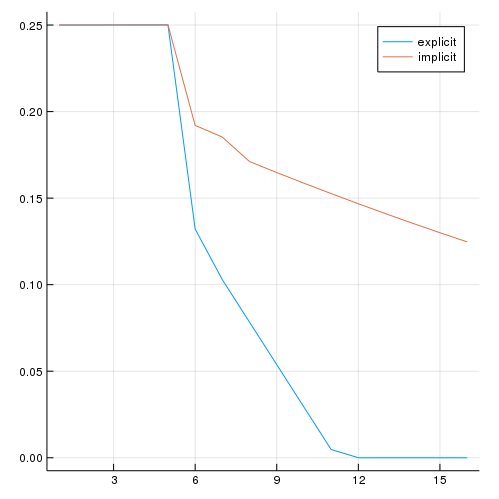

In [9]:
ts = cumsum([Δt for i in 1:N]);
j = 11
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")

In [ ]:
plot(sqrt.(sum(traj_exp[11:13,:].^2,1)[:]),label="explicit")
plot!(sqrt.(sum(traj_imp[11:13,:].^2,1)[:]),label="implicit")

In [ ]:
DrakeVisualizer.any_open_windows() || (DrakeVisualizer.new_window(); sleep(1));
geometries = visual_elements(mechanism, URDFVisuals(urdf))
vis = Visualizer(mechanism, geometries);

In [ ]:
traj = traj_exp
qs = [traj[1:num_positions(x0),i] for i in 1:N]
ts = cumsum([Δt for i in 1:N]);
RigidBodyTreeInspector.animate(vis, mechanism, ts, qs; realtimerate = .25);